In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving balanced_test_data_updated.csv to balanced_test_data_updated.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving balanced_train_data_updated.csv to balanced_train_data_updated.csv


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load data, Do Pre-Processing, Do Tokenization

In [ ]:
# Load your data
train_df = pd.read_csv('balanced_train_data_updated.csv')
test_df = pd.read_csv('balanced_test_data_updated.csv')

# Text preprocessing
def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return [word for word in text.split() if word not in stop_words]

In [ ]:
train_df['tokens'] = train_df['Text'].apply(preprocess)
test_df['tokens'] = test_df['Text'].apply(preprocess)

# Train Word2Vec on training tokens
w2v_model = Word2Vec(sentences=train_df['tokens'], vector_size=100, window=5, min_count=2, workers=4)

In [ ]:
# Helper function: get average word vectors for a document
def document_vector(tokens, model):
    valid_words = [word for word in tokens if word in model.wv]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[valid_words], axis=0)

In [ ]:
# Vectorize the train and test sets
X_train = np.array([document_vector(tokens, w2v_model) for tokens in train_df['tokens']])
X_test = np.array([document_vector(tokens, w2v_model) for tokens in test_df['tokens']])
y_train = train_df['Score']
y_test = test_df['Score']

# RandomForest Scores with Word2vec

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict and evaluate
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7384982214751984
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.76      8527
           1       0.72      0.64      0.68      8528
           2       0.75      0.80      0.77      8528

    accuracy                           0.74     25583
   macro avg       0.74      0.74      0.74     25583
weighted avg       0.74      0.74      0.74     25583



# Run the model with combined Attribute - Conbined

In [ ]:
# Combine Text and Summary
train_df['Combined'] = train_df['Summary'].fillna('') + " " + train_df['Text'].fillna('')
test_df['Combined'] = test_df['Summary'].fillna('') + " " + test_df['Text'].fillna('')

# Apply pro-processing on Combined and make new feature - tokens2

In [ ]:
train_df['tokens2'] = train_df['Combined'].apply(preprocess)
test_df['tokens2'] = test_df['Combined'].apply(preprocess)

# Train Word2Vec on training tokens
w2v_model = Word2Vec(sentences=train_df['tokens2'], vector_size=100, window=5, min_count=2, workers=4)

# Do Vectorization with combined feature

In [ ]:
# Vectorize the train and test sets
X_train2 = np.array([document_vector(tokens, w2v_model) for tokens in train_df['tokens2']])
X_test2 = np.array([document_vector(tokens, w2v_model) for tokens in test_df['tokens2']])
y_train2 = train_df['Score']
y_test2 = test_df['Score']

# RandomForest Scores for **Combined** Col with Word2vec

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train2, y_train2)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict and evaluate
y_pred2 = rf.predict(X_test2)
print("Accuracy:", accuracy_score(y_test2, y_pred2))
print("Classification Report:\n", classification_report(y_test2, y_pred2))

Accuracy: 0.7622249149826056
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78      8527
           1       0.74      0.67      0.71      8528
           2       0.78      0.82      0.80      8528

    accuracy                           0.76     25583
   macro avg       0.76      0.76      0.76     25583
weighted avg       0.76      0.76      0.76     25583



# Comparing the Results with and without Combined Col

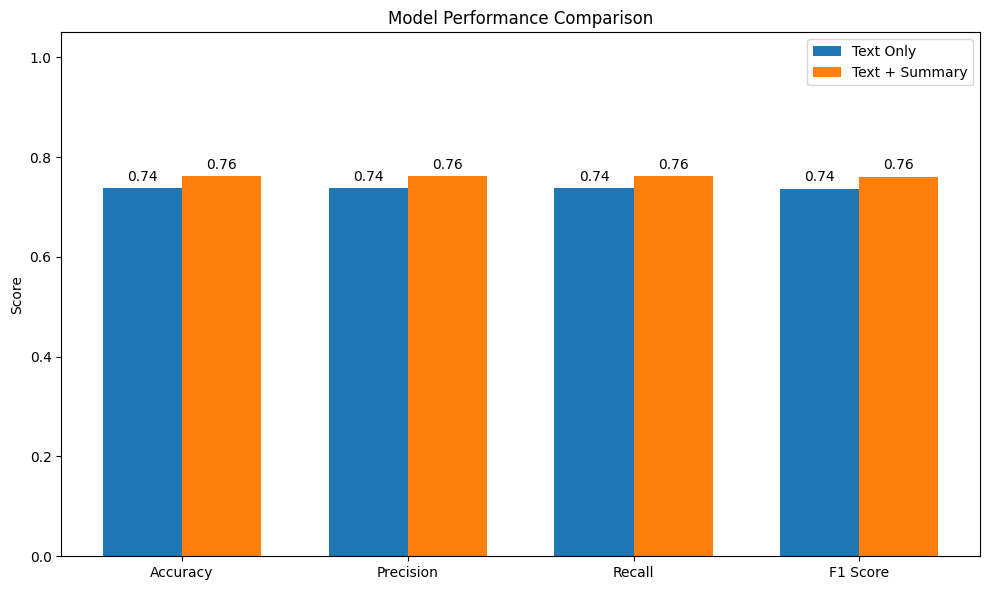

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics for both models
accuracy_text = accuracy_score(y_test, y_pred)
precision_text = precision_score(y_test, y_pred, average='weighted')
recall_text = recall_score(y_test, y_pred, average='weighted')
f1_text = f1_score(y_test, y_pred, average='weighted')

accuracy_combined = accuracy_score(y_test2, y_pred2)
precision_combined = precision_score(y_test2, y_pred2, average='weighted')
recall_combined = recall_score(y_test2, y_pred2, average='weighted')
f1_combined = f1_score(y_test2, y_pred2, average='weighted')

# Bar chart data
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
text_scores = [accuracy_text, precision_text, recall_text, f1_text]
combined_scores = [accuracy_combined, precision_combined, recall_combined, f1_combined]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, text_scores, width, label='Text Only')
bars2 = ax.bar(x + width/2, combined_scores, width, label='Text + Summary')

# Labels and Title
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.05)

# Display values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Let's Do Hyperparameter Tunning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import time

# Simplified parameter space
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# Model
rf = RandomForestClassifier(random_state=42)

# Randomized Search CV (faster setup)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Only 10 combinations
    cv=3,       # 2-fold CV to speed things up
    verbose=1,
    n_jobs=1,   # Avoid overloading Colab CPUs
    scoring='f1_weighted',
    random_state=42
)

# Time it
start = time.time()
random_search.fit(X_train2, y_train2)
print(f"\nRandomSearchCV took {time.time() - start:.2f} seconds.")

# Evaluation
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test2)

print("Best Parameters:\n", random_search.best_params_)
print("Improved Accuracy:", accuracy_score(y_test2, y_pred_best))
print("Improved Classification Report:\n", classification_report(y_test2, y_pred_best))


Fitting 3 folds for each of 10 candidates, totalling 30 fits

RandomSearchCV took 2977.06 seconds.
Best Parameters:
 {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 136}
Improved Accuracy: 0.763632099441035
Improved Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78      8527
           1       0.74      0.67      0.71      8528
           2       0.77      0.83      0.80      8528

    accuracy                           0.76     25583
   macro avg       0.76      0.76      0.76     25583
weighted avg       0.76      0.76      0.76     25583



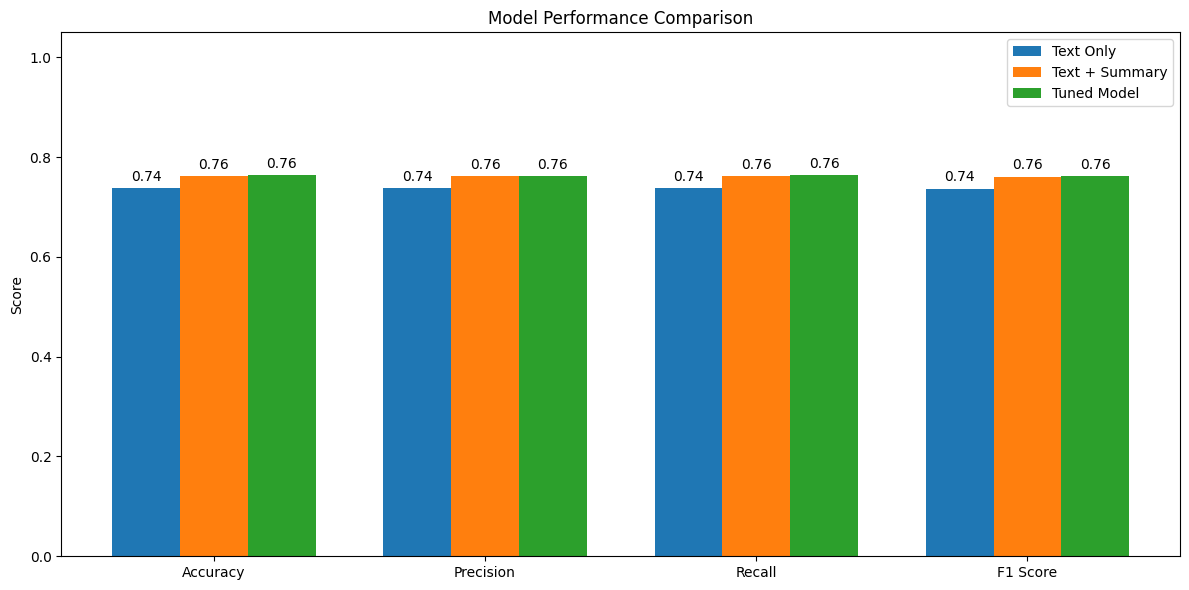

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Metrics: Text Only (Default)
accuracy_text = accuracy_score(y_test, y_pred)
precision_text = precision_score(y_test, y_pred, average='weighted')
recall_text = recall_score(y_test, y_pred, average='weighted')
f1_text = f1_score(y_test, y_pred, average='weighted')

# Metrics: Combined (Default)
accuracy_combined = accuracy_score(y_test2, y_pred2)
precision_combined = precision_score(y_test2, y_pred2, average='weighted')
recall_combined = recall_score(y_test2, y_pred2, average='weighted')
f1_combined = f1_score(y_test2, y_pred2, average='weighted')

# Metrics: Combined (Tuned)
accuracy_tuned = accuracy_score(y_test2, y_pred_best)
precision_tuned = precision_score(y_test2, y_pred_best, average='weighted')
recall_tuned = recall_score(y_test2, y_pred_best, average='weighted')
f1_tuned = f1_score(y_test2, y_pred_best, average='weighted')

# Data for plotting
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
text_scores = [accuracy_text, precision_text, recall_text, f1_text]
combined_scores = [accuracy_combined, precision_combined, recall_combined, f1_combined]
tuned_scores = [accuracy_tuned, precision_tuned, recall_tuned, f1_tuned]

x = np.arange(len(labels))  # label positions
width = 0.25  # bar width

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, text_scores, width, label='Text Only')
bars2 = ax.bar(x, combined_scores, width, label='Text + Summary')
bars3 = ax.bar(x + width, tuned_scores, width, label='Tuned Model')

# Labels & styling
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.05)
ax.legend()

# Add bar values
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()
